<a href="https://colab.research.google.com/github/Sharath-a26/Adversarial-Learning/blob/main/Deep_Convolutional_GAN_with_PGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile("drive/MyDrive/lc25000.zip") as zObject:
  zObject.extractall("dataset")

In [ ]:
import os
colon_folder = "dataset/lung_colon_image_set/colon_image_sets/colon_n"
for i in os.listdir(colon_folder):
  os.remove(colon_folder + "/" + i)
os.rmdir(colon_folder)

In [ ]:
lung_folder = "dataset/lung_colon_image_set/lung_image_sets/lung_n"
for i in os.listdir(lung_folder):
  os.remove(lung_folder + "/" + i)
os.rmdir(lung_folder)

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 734.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
import tensorflow.keras as keras
dataset = keras.utils.image_dataset_from_directory(
    "dataset",image_size = (64,64),batch_size=32, label_mode=None
)

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Found 15000 files.


## Rescaling the dataset to range 0-1


In [ ]:
dataset = dataset.map(lambda x:x/255.0)

## Sample Image

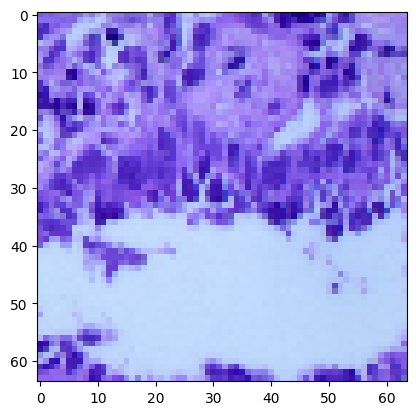

In [ ]:
import matplotlib.pyplot as plt
for i in dataset:
  plt.imshow((i.numpy() * 255).astype("int32")[0])
  break

## Discriminator

In [ ]:
from keras import layers
disc = keras.Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

In [ ]:
disc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## Generator

In [ ]:
input_latent_dim = 128

gen = keras.Sequential(
    [
        keras.Input(shape=(input_latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ]

)

In [ ]:
gen.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

## Gan training


In [ ]:
import random

def random_rotation(latent_vector):
    angle = random.uniform(-0.2, 0.2)
    return latent_vector * (1 + angle)

def random_translation(latent_vector):

    translation_factor = random.uniform(-0.2, 0.2)
    return latent_vector + translation_factor

def random_scaling(latent_vector):

    scaling_factor = random.uniform(0.8, 1.2)
    return latent_vector * scaling_factor

def random_noise(latent_vector):
    noise_factor = tf.random.normal(shape=tf.shape(latent_vector), mean=0.0, stddev=0.1)
    return latent_vector + noise_factor


def augment_latent_vector(latent_vector):
    latent_vector = random_rotation(latent_vector)
    latent_vector = random_translation(latent_vector)
    latent_vector = random_scaling(latent_vector)
    latent_vector = random_noise(latent_vector)
    return latent_vector


## PGD Attack Function

In [ ]:
import tensorflow as tf
from tqdm import tqdm
epsilon = 0.1   # total perturbation budget
alpha = 0.02    # step size per PGD iteration
pgd_steps = 5   # number of PGD steps

for epochs in range(10):
  for index, real in enumerate(tqdm(dataset)):
    batch_size = real.shape[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, input_latent_dim))

    perturbed_latent_vector = random_latent_vectors + tf.random.uniform(
        shape=tf.shape(random_latent_vectors),
        minval=-epsilon,
        maxval=epsilon
    )

    for step in range(pgd_steps):
        with tf.GradientTape() as gen_tape_pgd:
            gen_tape_pgd.watch(perturbed_latent_vector)
            fake_adv = gen(perturbed_latent_vector)
            output_adv = disc(fake_adv)
            loss_adv = loss_fn(tf.ones((batch_size, 1)), output_adv)

        grad_adv = gen_tape_pgd.gradient(loss_adv, perturbed_latent_vector)

        # PGD step
        perturbed_latent_vector = perturbed_latent_vector + alpha * tf.sign(grad_adv)


        perturbation = tf.clip_by_value(
            perturbed_latent_vector - random_latent_vectors,
            -epsilon,
            epsilon
        )
        perturbed_latent_vector = random_latent_vectors + perturbation

    # stop gradient so generator is updated, not the latent vector
    perturbed_latent = tf.stop_gradient(perturbed_latent_vector)

    with tf.GradientTape() as final_gen_tape:
        fake_adv = gen(perturbed_latent)
        output = disc(fake_adv)
        loss_gen = loss_fn(tf.ones((batch_size, 1)), output)

    gradients2 = final_gen_tape.gradient(loss_gen, gen.trainable_weights)

    opt_gen.apply_gradients(
        zip(gradients2, gen.trainable_weights)
    )


  0%|          | 2/469 [01:24<5:27:42, 42.10s/it]

In [ ]:
gen.save("/content/drive/My Drive/gen_with_pgd_epoch_10.h5")

## importing the saved model

In [ ]:
from tensorflow.keras.models import load_model
gen_model = load_model('/content/drive/My Drive/gen_with_fgsm_epoch_10.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_noise = tf.random.normal(shape = (5,input_latent_dim))
generated_images = gen_model(random_noise, training=False)

generated_images = generated_images.numpy()


img = generated_images[4]

img = (img*255).astype(np.uint8)

print(np.shape(img))
plt.imshow(img)